# A notebook which contains the dutch feature-set

# Import data

In [28]:
import pandas as pd
import re
import dutch_words
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, tqdm_pandas
import torch
import string
import nltk
from nltk.tag.perceptron import PerceptronTagger
import spacy
#from spacy import displacy
from tensorflow.keras.preprocessing.text import hashing_trick
#spacy.require_gpu()



tqdm.pandas()
dutch_wordslist = dutch_words.get_ranked()
df_ftm_first = pd.read_excel (r'preprocessed_final.xlsx', usecols=['id','type','title','abstract', 'abstract_length'])
df_ftm_new = pd.read_excel(r'preprocessed_final_new.xlsx', usecols=['id','title','abstract', 'abstract_length'])
df_ftm_new.id = df_ftm_new.id.apply(lambda x: str(x))
df_ftm = pd.concat([df_ftm_first, df_ftm_new]).reset_index()
df_ftm.drop(['index', 'type'], axis = 1,inplace=True)
df_ftm.abstract = df_ftm.abstract.apply(lambda x: str(x))
df_ftm.abstract = df_ftm.abstract.apply(lambda x: ' '.join(x.split()[:len(x.split())]))
df_ftm_full = df_ftm.copy()

df_ftm_asreview = pd.read_excel(r'asreview_dataset_ftm-splitted.xlsx')

In [30]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from num2words import num2words
from nltk.corpus import stopwords



In [31]:
# Download required NLTK packages
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MichaG\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\MichaG\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MichaG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Assign labels

### Assign labels for data

In [32]:
labels_adv = pd.read_csv(r'Adviestraject.csv', usecols=['tags', 'full_name'])
labels_NAM = pd.read_csv(r'RelatieAssenNAM.csv', usecols=['tags', 'full_name'])
labels_provincie = pd.read_csv(r'RelatieAssen-provincie.csv', usecols=['tags', 'full_name'])
labels_adv_new = pd.read_csv(r'Adviestraject.csv', usecols=['tags', 'full_name']).dropna()
labels_NAM_new = pd.read_csv(r'RelatieAssenNAM.csv', usecols=['tags', 'full_name']).dropna()
labels_provincie_new = pd.read_csv(r'RelatieAssenprovincie.csv', usecols=['tags', 'full_name']).dropna()
labels_drenthe4_new = pd.read_csv(r'Drenthe4.0.csv', usecols=['tags', 'full_name']).dropna()
labels_provincienam_new = pd.read_csv(r'RelatieprovincieNam.csv', usecols=['tags', 'full_name']).dropna()
labels_assennam_df = pd.concat([labels_NAM, labels_NAM_new], axis = 0)
labels_nonassennam_df = pd.concat([labels_adv, labels_provincie, labels_adv_new, labels_provincie_new, labels_drenthe4_new, labels_provincienam_new], axis = 0)

label_assennam = []
label_nonassennam = []
for id_ in df_ftm.id:
    for full_name_adv in labels_assennam_df.full_name:
        if id_ in full_name_adv:
            label_assennam.append(id_)
    for full_name_nonadv in labels_nonassennam_df.full_name:
        if id_ in full_name_nonadv:
            label_nonassennam.append(id_)

unique_label_assennam = list(set(label_assennam))
unique_label_nonassennam = list(set(label_nonassennam))
df_ftm['label_assennam'] = None
df_ftm['label_nonassennam'] = None
for i in range(0, len(df_ftm)):
    if df_ftm.id.loc[i] in unique_label_assennam:
        df_ftm.loc[i, 'label_assennam'] = 1
    else:
        df_ftm.loc[i, 'label_assennam'] = None
    if df_ftm.id.loc[i] in unique_label_nonassennam:
        df_ftm.loc[i, 'label_nonassennam'] = 1
    else:
        df_ftm.loc[i, 'label_nonassennam'] = None


In [33]:
for index,row in df_ftm.iterrows():
    if row.label_assennam == None and row.label_nonassennam == 1:
        df_ftm.loc[index,'label_assennam'] = 0

In [34]:
df_ftm.drop(['label_nonassennam'], axis=1, inplace=True)
df_ftm = df_ftm.dropna()
print('0:', df_ftm[df_ftm.label_assennam==0].shape[0], '1:',df_ftm[df_ftm.label_assennam==1].shape[0])


0: 416 1: 183


## Sentiment Analysis
First we import the Robbert model and run model.eval() to disable dropout

In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
model = AutoModelForSequenceClassification.from_pretrained("pdelobelle/robbert-v2-dutch-base" )
model.eval()
tokenizernlp = AutoTokenizer.from_pretrained("pdelobelle/robbert-v2-dutch-base")

Some weights of the model checkpoint at pdelobelle/robbert-v2-dutch-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier.dense.bias', 'classif

In [10]:
# Perform sentiment analysis on all rows
tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512}
sentiment_analysis = pipeline("sentiment-analysis" , model=model, tokenizer = tokenizernlp, device = 0) # Create pipeline for performing sentiment analysis
def generatesentimentvalues(text):
    sentiment_result = sentiment_analysis(text, **tokenizer_kwargs) # perform sentiment analysis on text
    if sentiment_result[0]['label'] == 'NEGATIVE': # As we can only use numbers for the final model, we need to transform the results from numbers with a label to purely numbers
        result = 0-sentiment_result[0]['score']
    else:
        result = sentiment_result[0]['score']
    return result
df_ftm['sentiment_score'] = df_ftm.abstract.progress_apply(lambda x: generatesentimentvalues(x))

  2%|▏         | 10/599 [00:02<01:53,  5.19it/s]C:\Users\MichaG\Anaconda3\lib\site-packages\transformers\pipelines\base.py:997: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 599/599 [00:54<00:00, 10.99it/s]


### Standard deviation of sentence lengths

In [198]:
def standard_dev_sentence_length(text):
    ''' Function that calulates the standard deviation of the length of all the sentences in a text.
    '''
    sentences = nltk.tokenize.sent_tokenize(text)
    sentence_length = []
    for item in sentences:
        sentence_length.append(len(item))
    return(np.std(sentence_length))

In [199]:
df_ftm['stdev_sentence_length'] = df_ftm.abstract.progress_apply(lambda x: standard_dev_sentence_length(x))

100%|██████████| 599/599 [00:00<00:00, 1271.87it/s]
C:\Users\MichaG\AppData\Local\Temp\ipykernel_21140\80542924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ftm['stdev_sentence_length'] = df_ftm.abstract.progress_apply(lambda x: standard_dev_sentence_length(x))


### Automated readability index

In [200]:
def readability_index(text):
    ''' Function that calculates the automated readability index of a text.
    '''
    sentences = nltk.tokenize.sent_tokenize(text)
    words = text.count(' ')
    characters = len(text) - words
    try:
        return(4.71*(characters/words) + 0.5*(words/len(sentences)) -21.43)
    except:
        return(0)

In [201]:
df_ftm['readability_index'] = df_ftm.abstract.progress_apply(lambda x: readability_index(x))

100%|██████████| 599/599 [00:00<00:00, 1523.69it/s]
C:\Users\MichaG\AppData\Local\Temp\ipykernel_21140\3760217583.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ftm['readability_index'] = df_ftm.abstract.progress_apply(lambda x: readability_index(x))


### Standard deviation of word lengths

In [40]:
def standard_dev_word_length(text):
    ''' Function that calculates the standard deviation of the word lengths in a text.
    '''
    words = text.split()
    words_length = []
    for word in words:
        words_length.append(len(word))
    return(np.std(words_length))

In [41]:
df_ftm['stdev_word_length'] = df_ftm.abstract.progress_apply(lambda x: standard_dev_word_length(x))

100%|██████████| 599/599 [00:00<00:00, 4684.98it/s]


### Type Token ratio

In [38]:
def type_token_ratio(text):
    ''' Function that calculates the type token ratio of the text. The type token ratio is the ratio between the toal amount of words and the amount of unique words in a text.
    '''
    unique = set(text.split()) 
    return len(unique)/ len(text.split())

In [39]:
df_ftm['type_token_ratio'] = df_ftm.abstract.progress_apply(lambda x:type_token_ratio(x))

100%|██████████| 599/599 [00:00<00:00, 5760.22it/s]


### Proper nouns

In [206]:
# This may take a few minutes. (But once loaded, the tagger is really fast!)
spacy_model = "nl_core_news_lg"
passive_tagger = spacy.load(spacy_model)

C:\Users\MichaG\Anaconda3\lib\site-packages\spacy\util.py:837: UserWarning: [W095] Model 'nl_core_news_lg' (3.0.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [207]:
def proper_nouns(text):
    ''' Function that caclulates how many proper nouns there are in a text. This is done with the help of the NLTK perceptron tagger.
    '''
    propernouns = 0 
    tagged_sent = passive_tagger(text)
    for i in range(0, len(tagged_sent)):
        if 'N|eigen' in tagged_sent[i].tag_:
            propernouns +=1
    return propernouns

In [208]:
df_ftm['proper_nouns'] = df_ftm.abstract.progress_apply(lambda x: proper_nouns(x))

100%|██████████| 599/599 [00:53<00:00, 11.22it/s]
C:\Users\MichaG\AppData\Local\Temp\ipykernel_21140\1253451810.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ftm['proper_nouns'] = df_ftm.abstract.progress_apply(lambda x: proper_nouns(x))


### Bag of words

### preprocessing tfidf

In [174]:
def convert_lower_case(text):
    return np.char.lower(text)
def remove_email_adresses(text):
    text = re.sub(r'\S*@\S*\s?', '', str(text))
    return text

In [175]:
def remove_stop_words(data):
    stop_words = stopwords.words('dutch')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text

In [176]:
def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

In [177]:
def remove_apostrophe(data):
    return np.char.replace(data, "'", "")

In [178]:
def stemming(data):
    stemmer= PorterStemmer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text
def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text
def remove_random_words(data):
    data = str(data)
    data = re.sub(r'\b(USL)?(usl)?\b', '', data)
    data = re.sub(r'\b(\.((DOC)?(doc)?))\b', '', data)
    data = re.sub(r'\b(e-mail)\b', '', data)
    data = re.sub(r'(\<div\>)', '', data)
    data = re.sub(r'(\<br\>)', '', data)
    data = re.sub(r'(.*?\.[\w:]+)', '', data)
    data = re.sub(r'\[image\]', '', data)
    #data = re.sub(r'\b3d\b', '', data)
    return data

In [179]:
def remove_numbers_phonenumbers(text):
    ''' Function that remove specific sequences of numbers from a text so that they are not seen as words by the BagofWords feature.
    '''
    text = str(text)
    #text = re.sub(r'\b([0-9]{3}-[0-9]{3}-[0-9]{4})\b', '', text) #Remove US phone numbers
    text = re.sub(r'\b([0-1][0-9]\/[0-3][0-9]\/[0-9]{4})\b', '', text) #Removes dates
    text = re.sub(r'\b([0-1]?[0-9]):[0-5][0-9]\b', '', text) #Removes timestamps
    text = re.sub(r'\b\w*\d\w*\b', '', text) #Removes single whitespaces
    return(text)

In [180]:
def preprocess(data):
    data = convert_lower_case(data)
    data = remove_email_adresses(data)
    data = remove_random_words(data)
    data = remove_punctuation(data) #remove comma seperately
    data = remove_apostrophe(data)
    data = remove_stop_words(data)
    data = remove_numbers_phonenumbers(data)
    data = stemming(data)
    data = remove_punctuation(data)
    data = remove_numbers_phonenumbers(data)
    data = stemming(data) #needed again as we need to stem the words
    data = remove_punctuation(data) #needed again as num2word is giving few hypens and commas fourty-one
    data = remove_stop_words(data) #needed again as num2word is giving stop words 101 - one hundred and one

    return data

In [181]:
df_ftm_bow = df_ftm_full.copy() #Create copy so that we dont modify the actual dataframe

df_ftm_bow.abstract = df_ftm_bow .abstract.progress_apply(lambda x: word_tokenize(str(preprocess(x))))

100%|██████████| 13593/13593 [45:04<00:00,  5.03it/s]  


In [182]:
DF = {}

for i in range(0,len(df_ftm_bow)):
    tokens = df_ftm_bow.abstract.iloc[i]
    for w in tokens:
        try:
            DF[w].add(i)
        except:
            DF[w] = {i}
for i in DF:
    DF[i] = len(DF[i])

In [183]:
def doc_freq(word):
    c = 0
    try:
        c = DF[word]
    except:
        pass
    return c

In [184]:
N = len(df_ftm_bow)
doc = 0

tf_idf = {}
df_tfidf = pd.DataFrame({'Doc': pd.Series(dtype='str'),
                   'term': pd.Series(dtype='str'),
                   'value': pd.Series(dtype='float'),
                   'label': pd.Series(dtype='int')})
for i in tqdm(range(0,N)):
    tokens = df_ftm_bow.abstract.iloc[i]
    
    counter = Counter(tokens)
    words_count = len(tokens)
    
    for token in np.unique(tokens):
        
        tf = counter[token]/words_count
        df = doc_freq(token)
        idf = np.log((N+1)/(df+1))
        
        tf_idf[doc, token] = tf*idf
        #df_tfidf.loc[len(df_tfidf)] = [doc,token,tf*idf, enron_df.loc[doc].label]

    doc += 1


100%|██████████| 13593/13593 [00:09<00:00, 1422.00it/s]


### Bag of words with hashes

### preprocessing bow

In [185]:
df_ftm_bow_new = df_ftm_full.copy()
df_ftm_bow_new['abstract'] = df_ftm_bow_new.abstract.progress_apply(lambda x: preprocess(x))

100%|██████████| 13593/13593 [40:13<00:00,  5.63it/s]  


In [186]:
def Hashed_BOW(text, length):
    bow_array = [0]*length
    hashes = hashing_trick(
        text,
        length,
        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
        lower=True,
        split=' ',
        analyzer=None)
    for hash_ in hashes:
        bow_array[hash_] = bow_array[hash_]+1
    
    return bow_array[0:length]


In [187]:
BOW_df = pd.DataFrame(columns=[str(i) for i in range(0,1001)])


for i in tqdm(range(len(df_ftm_bow_new))):
    BOW_values = Hashed_BOW(df_ftm_bow_new.abstract.loc[i], 1001)
    BOW_df.loc[i] = BOW_values

100%|██████████| 13593/13593 [05:47<00:00, 39.14it/s]


In [188]:
for key in tqdm(tf_idf):
    BOW_df[str(hashing_trick(key[1], 1001, lower=True)[0])].iloc[key[0]] = BOW_df[str(hashing_trick(key[1], 1001, lower=True)[0])].iloc[key[0]]*tf_idf[key]

  0%|          | 0/1662661 [00:00<?, ?it/s]C:\Users\MichaG\AppData\Local\Temp\ipykernel_21140\1671212382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BOW_df[str(hashing_trick(key[1], 1001, lower=True)[0])].iloc[key[0]] = BOW_df[str(hashing_trick(key[1], 1001, lower=True)[0])].iloc[key[0]]*tf_idf[key]
100%|██████████| 1662661/1662661 [03:12<00:00, 8653.66it/s] 


### Concatenate bow_df and normal_df

In [31]:
ftm_df_final = df_ftm.copy()
ftm_df_final.rename(columns={"label_assennam": "label"}, inplace=True)

In [45]:
ftm_df_final = pd.concat((df_ftm.copy(), BOW_df_test.copy()), axis = 1) #Concatenate the BagOfWords dataframe with the other dataframe
ftm_df_final.rename(columns={"label_assennam": "label"}, inplace=True)
ftm_df_final = ftm_df_final.astype({'label': 'float64'})


<AxesSubplot:xlabel='label'>

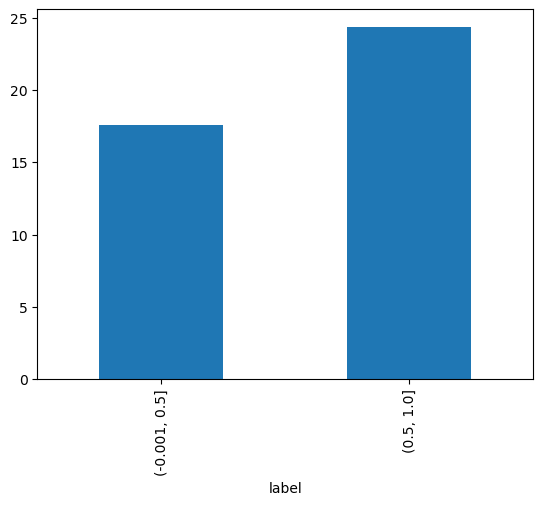

In [254]:
ftm_df_final.groupby(pd.cut(ftm_df_final.label, 2))['proper_nouns'].mean().plot.bar()

In [39]:
ftm_df_final

,id,title,abstract,abstract_length,label
41,16.10,brief naar NAM tbv put-10.pdf_,Stoppen opstarten gaswinning put Vries- Op vri...,4196,0
42,16.5,161206 advies Tcbb inzake Westerveld (NAM).pdf_,Technische nn > Retouradres Postbus EK Den Haa...,7154,1
48,16.9,brief EZ verzoek tot uitbrengen van advies.pdf_,> Retouradres Postbus EK Den Haag college van ...,6733,0
50,16.4,161019 advies SodM inzake winningsplan Westerv...,Contactpersoon Advies Westerveld | E-mail Door...,6319,0
51,16.7,advies Sodm.pdf_,Contactpersoon Advies Westerveld E-mail nn Doo...,6272,1
...,...,...,...,...,...
13582,Deel_10_96497510_,RE Benodigde informatie per project ELENA-aanv...,"ELENA Beste allemaal, Graag informeer ik julli...",994,0
13583,Deel_5_51565_,1-pressure cooker tbv transitieplan nav gasbes...,: Pressure cooker Energietransitie Gasbesluit ...,13475,0
13584,Deel_5_51565_,1-pressure cooker tbv transitieplan nav gasbes...,: Pressure cooker Transitie Gasbesluit Drenthe...,6822,0
13585,Deel_10_99299310_,RE Drenthe 4.0 Agenda Stakeholderbijeenkomst 4...,RE: Drenthe .: Agenda Stakeholderbijeenkomst d...,495,0


# Testing features

In [134]:
#Performing testing of the model. By using stratify we can simulate training the model using a much small dataset and we can make sure that the ratio of labels in the train and test set is the same as in the orignal dataset
from imblearn.over_sampling import RandomOverSampler, SMOTE 
from sklearn.model_selection import train_test_split  #For oversampling


#ftm_df_lr = ftm_df_final.drop(['abstract', 'title', 'id'], axis=1) #Create copy so we don't modify the original dataframe
ftm_df_lr = train_labeled_ftm.drop(['abstract', 'title', 'id'], axis=1) #Create copy so we don't modify the original dataframe

ftm_df_small = None
X_train, X_test, y_train, y_test = train_test_split(ftm_df_lr.drop(['label'],axis=1), 
                                                    ftm_df_lr['label'], test_size= 9, random_state=23)
#ros = RandomOverSampler(random_state=0)
#sm = SMOTE(random_state = 0)
#X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train) #Oversmampling train test set

X_train

,abstract_length,sentiment_score,type_token_ratio,stdev_word_length,0,1,2,3,4,5,...,991,992,993,994,995,996,997,998,999,1000
9518,67930,0.570313,0.305218,4.225936,0,0.004329,0.0,0.001690,0.00000,0.0,...,0.100876,0.004862,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
13394,9211,0.551028,0.427914,4.119976,0,0.000000,0.0,0.032794,0.01073,0.0,...,0.000124,0.000000,0.009660,0.004498,0.0,0.000000,0.000000,0.0,0.000000,0.000000
2546,60,0.535478,1.000000,2.657391,0,0.000000,0.0,0.000000,0.00000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
435,9704,0.551590,0.445985,4.204146,0,0.000000,0.0,0.003470,0.00000,0.0,...,0.005831,0.006701,0.005457,0.004549,0.0,0.005940,0.005352,0.0,0.012375,0.000000
13527,4663,0.531646,0.497872,3.950862,0,0.000000,0.0,0.000000,0.00000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013,77,0.582179,1.000000,4.261455,0,0.000000,0.0,0.000000,0.00000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
237,3507,0.573347,0.575488,3.030035,0,0.000000,0.0,0.035687,0.00000,0.0,...,0.000000,0.000000,0.024319,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
9524,1112,0.566971,0.716667,3.124628,0,0.000000,0.0,0.000000,0.00000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.039393,0.000000,0.0,0.000000,0.000000
4049,463,0.540981,0.783333,3.774917,0,0.000000,0.0,0.000000,0.00000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000


In [135]:
len(X_train)

390

In [136]:
#Perform grid search to find optimal configuration. Takes a long time to do since there are 200+ variables
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# define models and parameters
logmodel = LogisticRegression(max_iter = 1700, class_weight = 'balanced')
solvers = ['liblinear']
penalty = ['l2']
c_values = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.03, 0.025, 0.02, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
grid_search = GridSearchCV(estimator=logmodel, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1_weighted',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print(classification_report(y_test, grid_result.best_estimator_.predict(X_test)))

Best: 0.753112 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.753112 (0.063009) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.748367 (0.058701) with: {'C': 0.9, 'penalty': 'l2', 'solver': 'liblinear'}
0.743413 (0.061466) with: {'C': 0.8, 'penalty': 'l2', 'solver': 'liblinear'}
0.745749 (0.058526) with: {'C': 0.7, 'penalty': 'l2', 'solver': 'liblinear'}
0.740553 (0.059597) with: {'C': 0.6, 'penalty': 'l2', 'solver': 'liblinear'}
0.733522 (0.061625) with: {'C': 0.5, 'penalty': 'l2', 'solver': 'liblinear'}
0.723534 (0.067555) with: {'C': 0.4, 'penalty': 'l2', 'solver': 'liblinear'}
0.717538 (0.068931) with: {'C': 0.3, 'penalty': 'l2', 'solver': 'liblinear'}
0.707419 (0.062958) with: {'C': 0.2, 'penalty': 'l2', 'solver': 'liblinear'}
0.686400 (0.061905) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.672668 (0.060325) with: {'C': 0.05, 'penalty': 'l2', 'solver': 'liblinear'}
0.646353 (0.062059) with: {'C': 0.03, 'penalty': 'l2', 'solver': 'liblinear'}
0.

In [214]:
df_coef = pd.DataFrame(pd.Series(grid_result.best_estimator_.coef_[0]), columns=['coef'])
#df_coef = pd.concat([df_coef, pd.Series(grid_result.best_estimator_.coef_[0])], axis = 0)
#df_coef = df_coef.append(pd.Series(grid_result.best_estimator_.coef_[0]), ignore_index=True)
#grid_result.best_estimator_.coef_[0]
df_coef['colnames'] = X_train.columns
# Remove bag of words feature from coefficients
for index, row in df_coef.iterrows():
    if re.search(r'[0-9]', row.colnames):
        df_coef.drop([index], inplace=True)
df_coef.sort_values(['coef'])


,coef,colnames
4,-0.160220,stdev_word_length
3,-0.011602,readability_index
6,-0.005851,proper_nouns
0,0.000022,abstract_length
2,0.001346,stdev_sentence_length
5,0.030723,type_token_ratio
1,0.136222,sentiment_score


## Holdout set scores

In [74]:
holdout_set = pd.read_csv(r'holdout_set_ftm_with_features.csv', index_col=[0])
holdout_set_ytrue = holdout_set.label
holdout_set = holdout_set.drop(['label'], axis = 1)


In [137]:
print(classification_report(holdout_set_ytrue, grid_result.best_estimator_.predict(holdout_set)))

              precision    recall  f1-score   support

         0.0       0.80      0.82      0.81       143
         1.0       0.51      0.47      0.49        57

    accuracy                           0.72       200
   macro avg       0.65      0.65      0.65       200
weighted avg       0.71      0.72      0.72       200



### Create BOW_subset

In [201]:
BOW_df_subset = BOW_df_labeled.loc[train_labeled_ftm.index.values]
BOW_df_subset.to_excel(r'bowdf1001_ftm_subset.xlsx')

### Create ASReview subset

In [89]:
# With splitted documents
asreview_set = ftm_df_final.drop(holdout_labeled_ftm.index.values, axis=0) #remove testset from full set
#asreview_set[['id', 'title', 'abstract', 'label']].to_excel(r'asreview_split_train.xlsx')

# With labels
areview_set = ftm_df_final.drop(holdout_labeled_ftm.index.values, axis=0)
asreview_set[['id', 'title', 'abstract', 'label']].to_excel(r'asreview_split_train.xlsx')

In [131]:
# With no splitted documents
asreview_set = ftm_df_final.drop(holdout_labeled_ftm.index.values, axis=0) #remove testset from full set
asreview_set[['id', 'title', 'abstract', 'label']].to_excel(r'asreview_nosplit_train.xlsx')

### Create bag of words variable for asreview

In [267]:
BOW_df_asreview_ftm = BOW_df_test.copy()
BOW_df_asreview_ftm.drop(holdout_labeled_ftm.index.values, axis = 0, inplace = True)
BOW_df_asreview_ftm.to_excel(r'bowdf1001_ftm_train.xlsx')

In [24]:
train_labeled_ftm

,id,title,abstract,abstract_length,label
113,6.6,IB 200607018 Orienterend milieukundig bodemond...,Oriënterend milieukundig bodemonderzoek NAM-lo...,1508,1
1002,16133,beroep winningsplan Westerveld,: beroep winningsplan Westerveld Attachment : ...,1349,0
3738,16.58,170220 uitnodiging overheden informatieavonden...,planning vervolg winningsplan Westerveld (NAM)...,2352,0
4775,31.211,RE Reactie NAM op uw verzoek tav gaswinning A...,: RE: Reactie NAM op uw verzoek tav gaswinning...,261,1
104,6.1,IB 2008.4177 Grondwateronderzoek NAM-locatie (...,Grondwateronderzoek NAM-locatie (Vries ) op he...,6765,1
...,...,...,...,...,...
2458,16.1188,stukken WOB verzoek rond schadeafhandeling (19),"Re: concept Beste mensen, Alvast dank voor jul...",838,1
213,4.1,IB 2007-1672 Verzoek van NAM om instemming met...,Verzoek om instemming winningsplan Assen Excel...,1574,1
9587,Deel_17_4503450517_,actielijst Regulier bestuurlijk overleg Drenth...,"Date : -- :: From: To : ""Henk Brink"" ""Tjisse S...",2321,0
279,16.580,processchema,: processchema Attachment : processchema bespr...,97,0


### Create bag of words variable for simulation run

In [27]:
BOW_df_asreview_ftm = BOW_df_test.copy()
BOW_df_asreview_ftm = BOW_df_asreview_ftm.loc[train_labeled_ftm.index.values]
BOW_df_asreview_ftm.to_csv(r'bowdf1001_ftm_subset_adjusted.csv')

In [26]:
BOW_df_asreview_ftm

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
113,0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.020822,0.0
1002,0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
3738,0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.012471,0.0
4775,0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
104,0,0.0,0.015879,0.015615,0.000000,0.0,0.000000,0.000000,0.0,0.027151,...,0.000000,0.0,0.009937,0.000000,0.0,0.000000,0.0,0.0,0.012538,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2458,0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
213,0,0.0,0.096054,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.024653,0.000000,0.0,0.000000,0.0,0.0,0.018279,0.0
9587,0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
279,0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0


### Create holdout set with features

In [51]:
holdout_set_withfeatures = holdout_labeled_ftm.copy()
holdout_set_withfeatures = holdout_set_withfeatures.drop(['id', 'title', 'abstract'], axis=1)
holdout_set_withfeatures.to_csv(r'holdout_set_ftm_with_features.csv')

In [53]:
pd.read_csv(r'holdout_set_ftm_with_features.csv', index_col=[0])

,abstract_length,sentiment_score,type_token_ratio,stdev_word_length,0,1,2,3,4,5,...,992,993,994,995,996,997,998,999,1000,label
1417,1272,0.557605,0.644670,3.750324,0,0.0,0.00000,0.000000,0.0,0.0,...,0.000000,0.000000,0.027861,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2835,747,0.545289,0.763636,4.310865,0,0.0,0.00000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.079478,0.0,0.0,0.0
2859,405,0.568089,0.863014,2.370378,0,0.0,0.00000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1384,199,0.597729,0.962963,4.060584,0,0.0,0.00000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2862,1074,0.576313,0.860759,4.409244,0,0.0,0.00000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,6756,0.543242,0.411531,3.832664,0,0.0,0.00605,0.000000,0.0,0.0,...,0.000000,0.044645,0.185172,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4183,328,0.556578,0.940000,3.811824,0,0.0,0.00000,0.000000,0.0,0.0,...,0.000000,0.156447,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
13560,5584,0.566664,0.487064,3.419992,0,0.0,0.00000,0.010984,0.0,0.0,...,0.000374,0.000000,0.000000,0.0,0.035471,0.0,0.000000,0.0,0.0,0.0
9600,2624,0.576486,0.654179,4.166778,0,0.0,0.00000,0.000000,0.0,0.0,...,0.000000,0.000000,0.024144,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
